In [1]:
source('../../source/basic.r')

source('../validataion.r')


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”


In [2]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v75)
    library(EnsDb.Hsapiens.v86)
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

In [ ]:
# load seurat object provided by original paper to filter cells

In [3]:
mat = readRDS('data/original.seuratObject.rds')

In [4]:
mat

An object of class Seurat 
18404 features across 68458 samples within 1 assay 
Active assay: RNA (18404 features, 0 variable features)
 1 dimensional reduction calculated: umap

In [6]:
files <- list.files('data/',pattern ='.mtx')%>%gsub('_fragments.tsv.gz.mtx','',.)

In [7]:
files

[1] "GSM5837793_Control6" "GSM5837794_DN1"      "GSM5837795_DN2"     
[4] "GSM5837796_DN3"      "GSM5837798_DN4"      "GSM5837800_DN5"     
[7] "GSM5837801_DN6"      "GSM5837802_DN7"

In [9]:
fun_all <- function(file){
    
    counts <- readMM(paste0('data/',file,'_fragments.tsv.gz.mtx')) 


    colnames(counts) <- fread(paste0('data/',file,'_filtered_peak_bc_matrix.h5.barcode'),header = FALSE)%>%
                        pull(V1)

    rownames(counts) <-  fread('../../trans2cPeaks/cPeaks_hg38.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)

    metadata <- mat@meta.data%>%dplyr::filter(donor_id==paste0('diabetic_',str_extract(file,'(?<=_DN).*')))
    rownames(metadata) <- rownames(metadata)%>%gsub('-.$|-..$','-1',.)
    


    chrom_assay <- CreateChromatinAssay(
      counts = counts,
      sep = c(":", "-"),
      genome = 'hg38',
      fragments = paste0('data/',file,'_fragments.tsv.gz'),
      min.cells = 0,
      min.features = 0
    )


    seurat.object.all <- CreateSeuratObject(
      counts = chrom_assay,
      assay = "peaks",
      meta.data = metadata
    )

    seurat.object <- subset(seurat.object.all, cells = rownames(metadata))


    
    seurat.object <- RunTFIDF(seurat.object)
    seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
    seurat.object <- RunSVD(seurat.object)

    DepthCor(seurat.object)

    seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3)
    # p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()

    p.umpa.cluster = DimPlot(object = seurat.object, label = TRUE) + NoLegend()


    p.umpa.label = DimPlot(object = seurat.object,group.by='cell_type',label = TRUE) + NoLegend()


    p.umpa.label2 = DimPlot(object = seurat.object,group.by='author_cell_type',label = TRUE) + NoLegend()
    
    return(list(object=seurat.object, p=list(p.umpa.cluster,p.umpa.label,p.umpa.label2)))
}


In [11]:
files%>%.[grep('DN',.)]

[1] "GSM5837794_DN1" "GSM5837795_DN2" "GSM5837796_DN3" "GSM5837798_DN4"
[5] "GSM5837800_DN5" "GSM5837801_DN6" "GSM5837802_DN7"

In [12]:
res.all <- mclapply(files%>%.[grep('DN',.)],fun_all,mc.cores = 7)

In [16]:
psize(6,6)

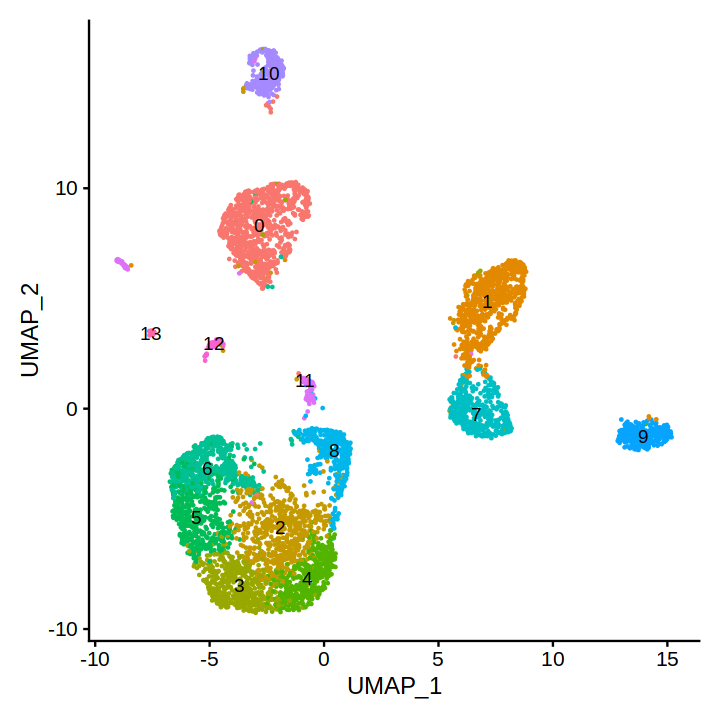

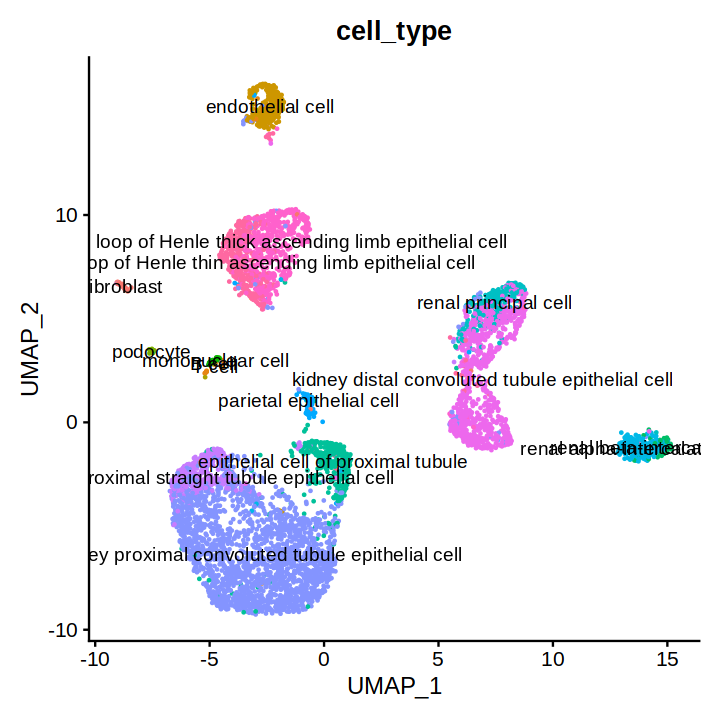

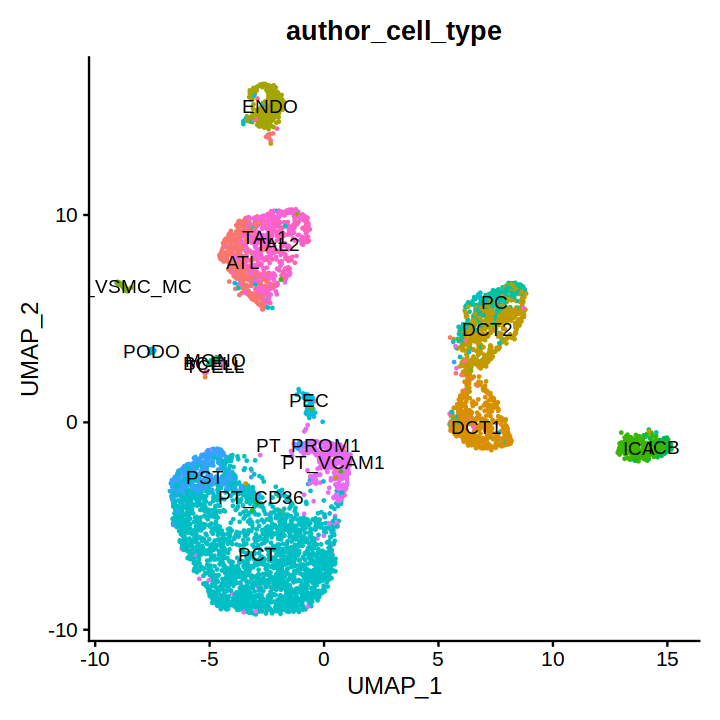

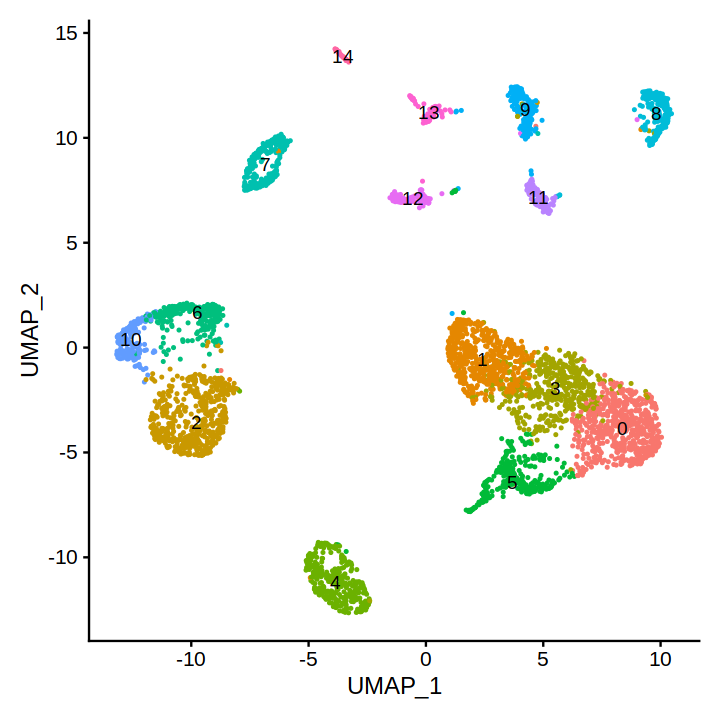

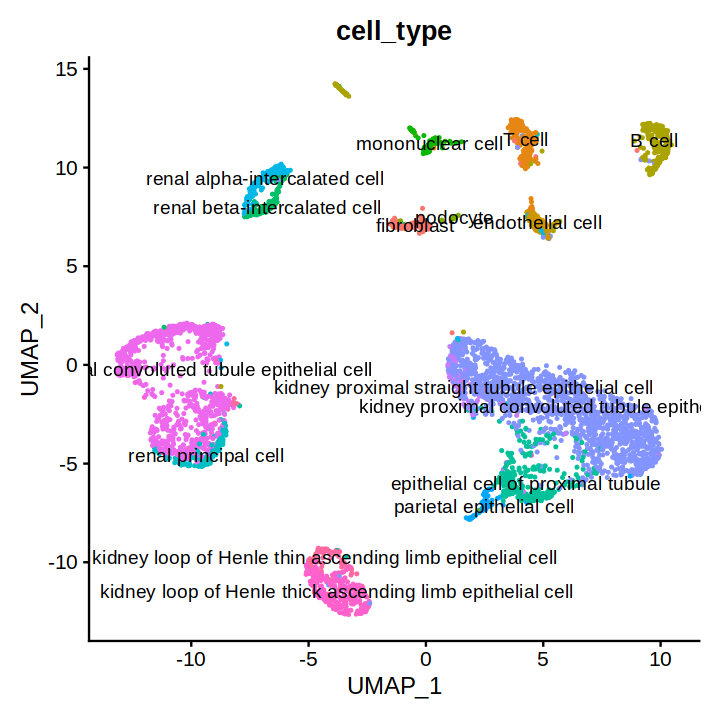

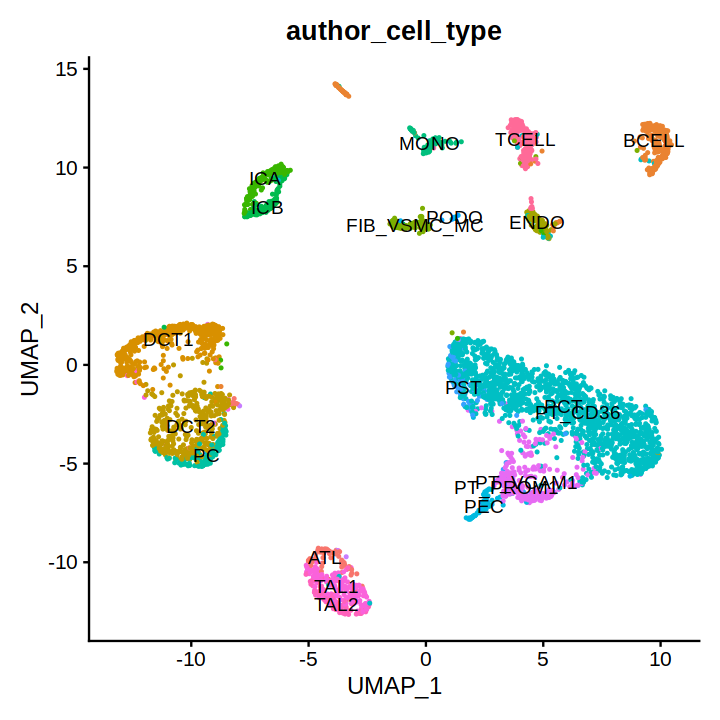

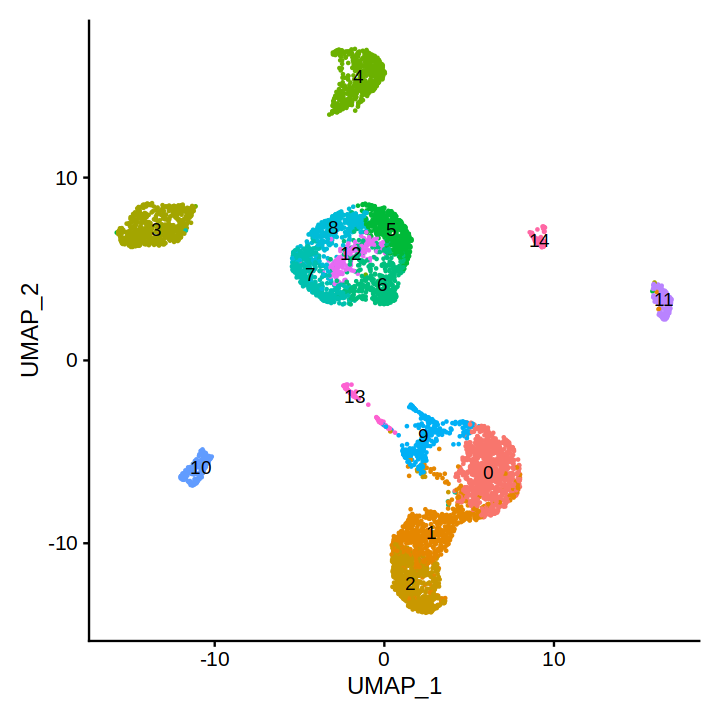

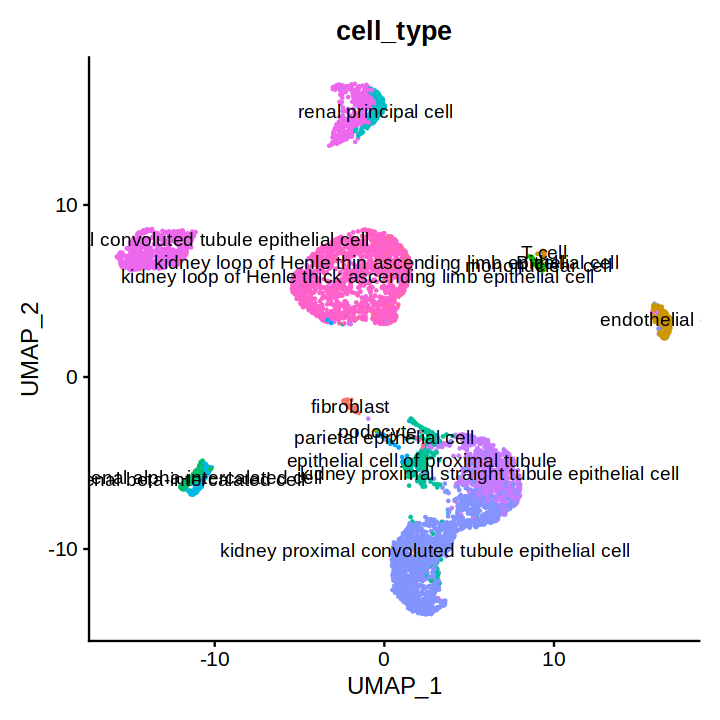

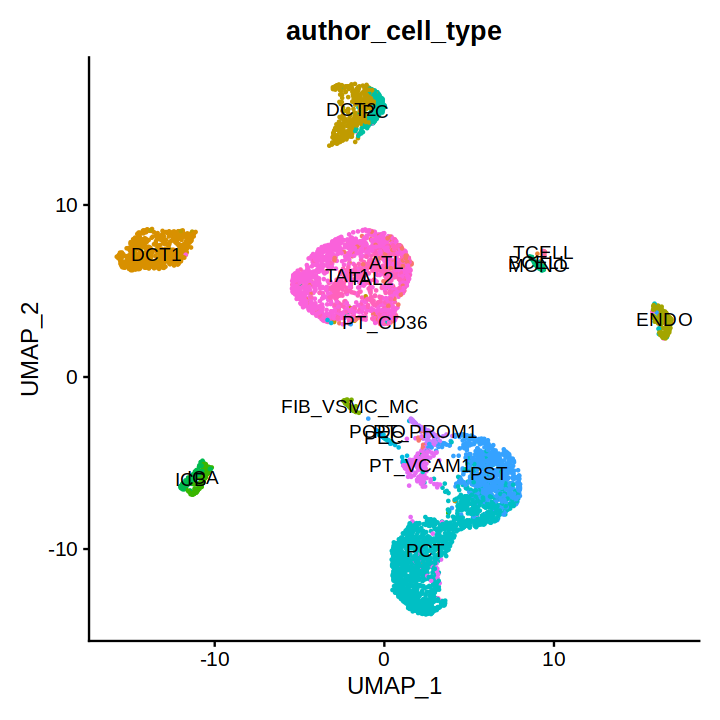

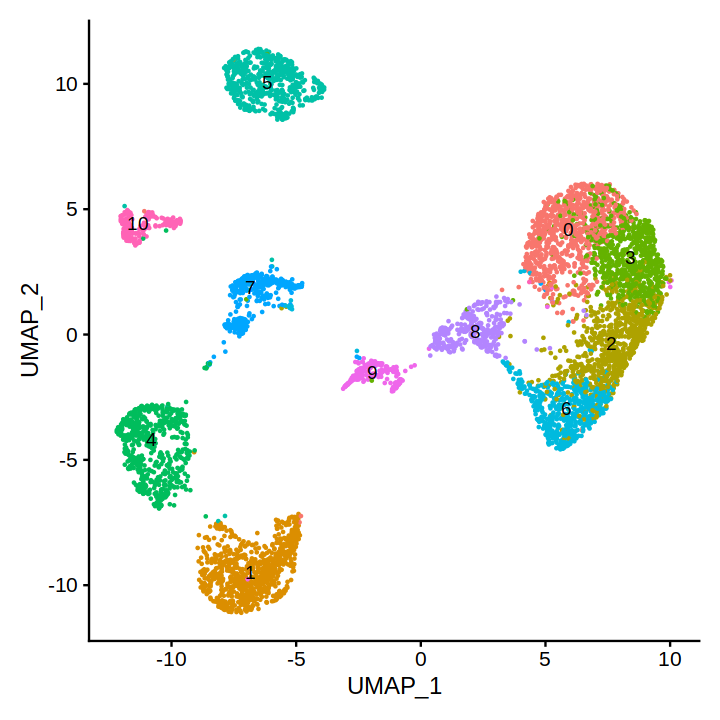

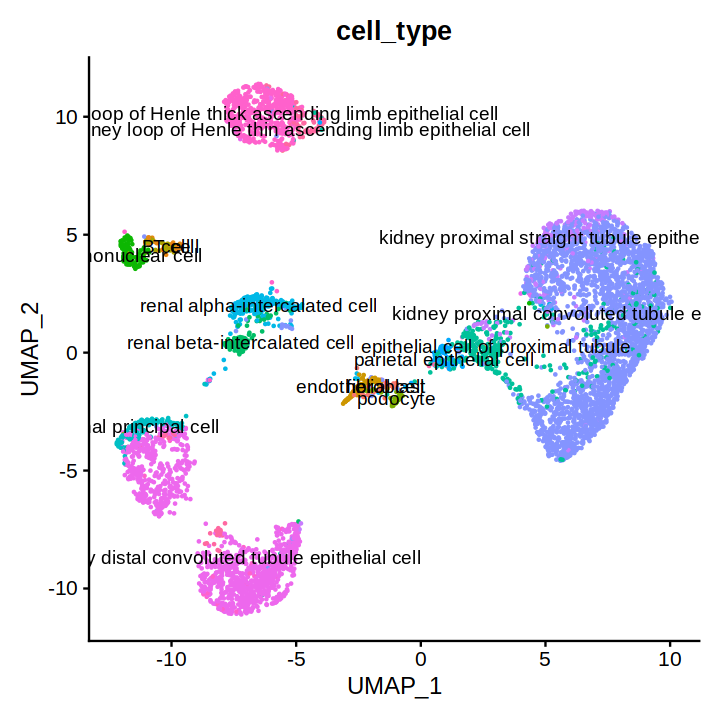

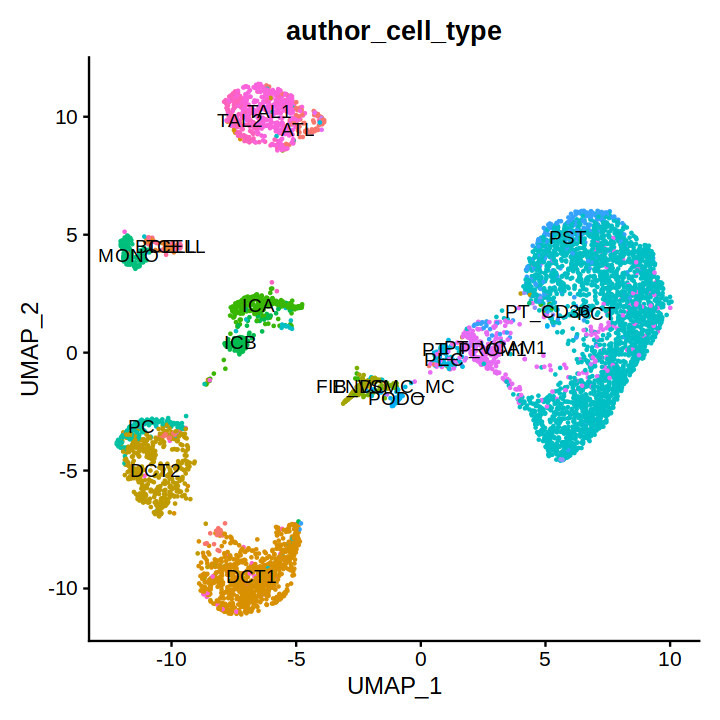

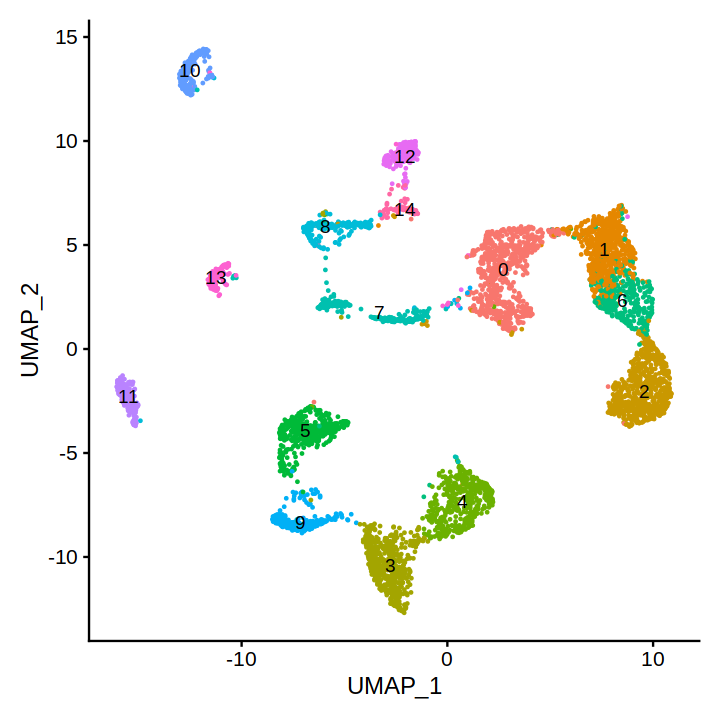

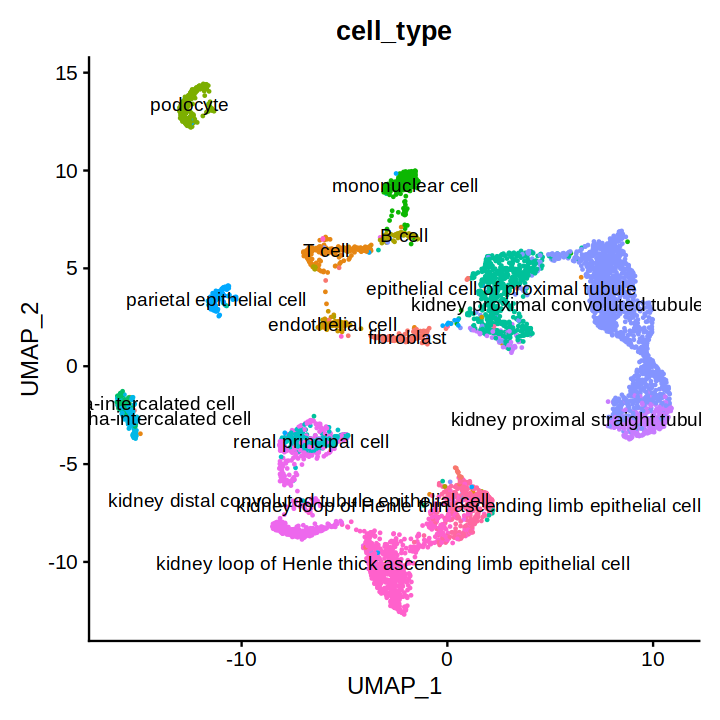

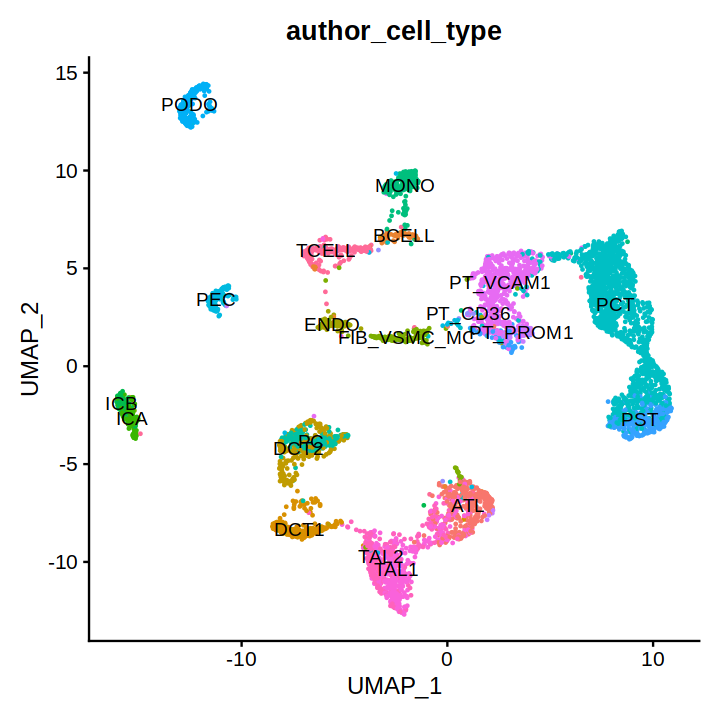

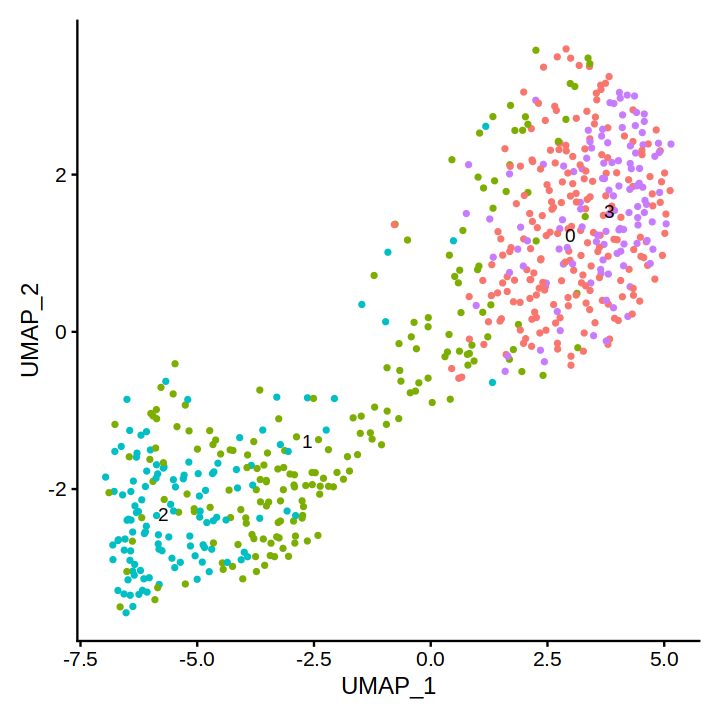

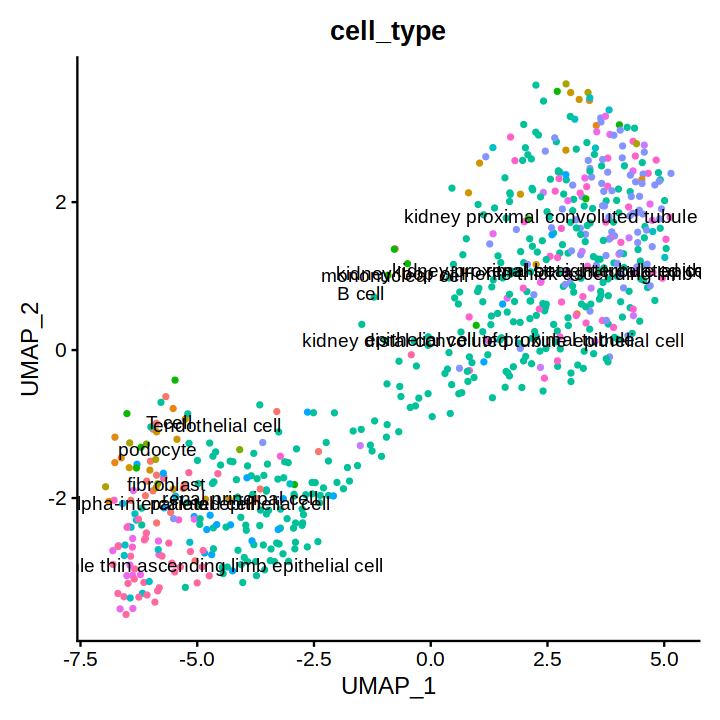

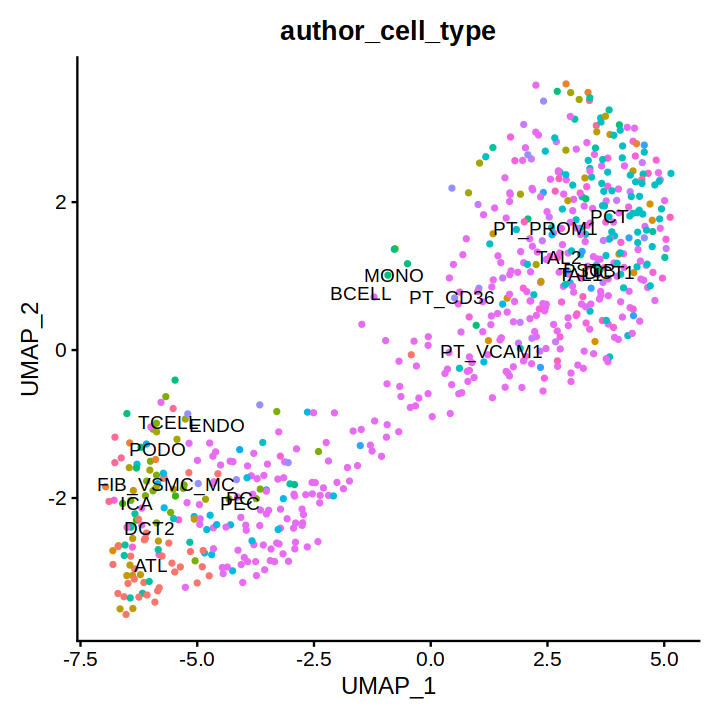

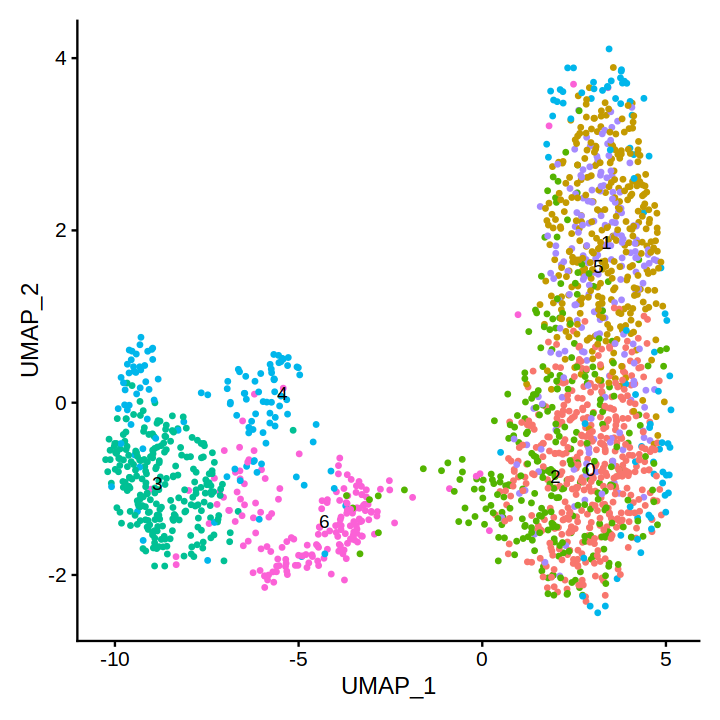

[[1]]
[[1]][[1]]

[[1]][[2]]

[[1]][[3]]


[[2]]
[[2]][[1]]

[[2]][[2]]

[[2]][[3]]


[[3]]
[[3]][[1]]

[[3]][[2]]

[[3]][[3]]


[[4]]
[[4]][[1]]

[[4]][[2]]

[[4]][[3]]


[[5]]
[[5]][[1]]

[[5]][[2]]

[[5]][[3]]


[[6]]
[[6]][[1]]

[[6]][[2]]

[[6]][[3]]


[[7]]
[[7]][[1]]

[[7]][[2]]

[[7]][[3]]



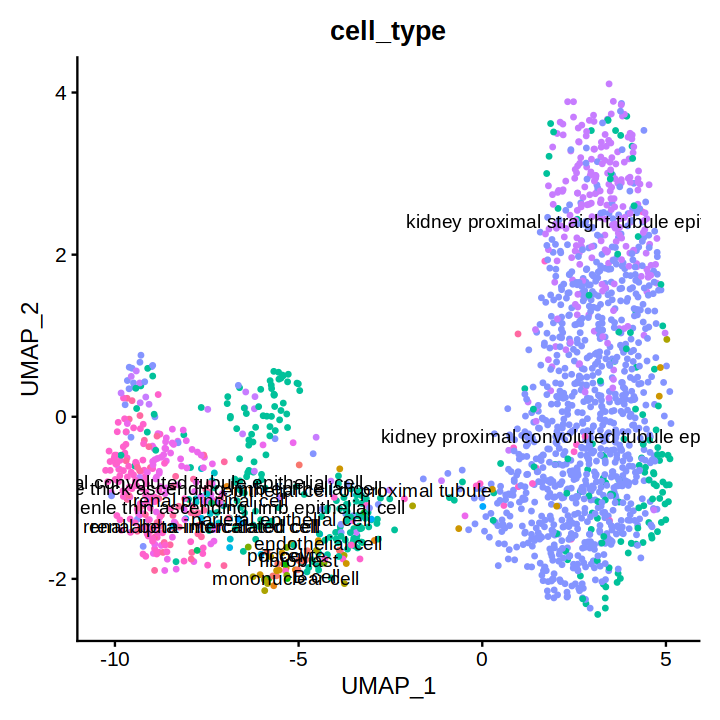

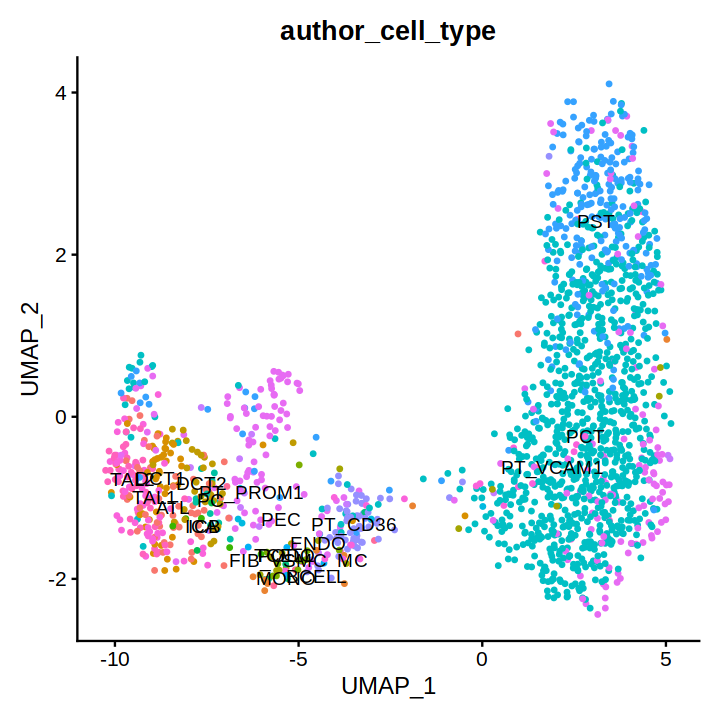

In [18]:
(res.all)%>%lapply(function(x)({(x$p)+theme()}))

In [ ]:
lapply(res.all,function(x){x$p})

In [24]:
pdf('plot/patient_all.pdf',height = 7,width = 6)
for(i in 1:5){
    seurat.object = res.all[[i]][[1]]
    tmp = seurat.object@meta.data%>%group_by(author_cell_type)%>%summarise(n=n())%>% dplyr::filter(n>10)%>%pull(author_cell_type)%>%as.character

    p.ump.cluster = DimPlot(object = seurat.object, cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,label = TRUE) + NoLegend()
    (p.ump.cluster+theme(aspect.ratio = 1)+ggtitle(paste0('patient ',i)))%>%print
    #ggsave(paste0('plot/all-DN',i,'-clusters.pdf'),height = 10,width = 15)
    p.ump.label = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='cell_type',label = TRUE) + NoLegend()
    (p.ump.label+theme(aspect.ratio = 1)+ggtitle(paste0('patient ',i)))%>%print
    #ggsave(paste0('plot/all-DN',i,'-umap1.pdf'),height = 10,width = 15)
    p.ump.label2 = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='author_cell_type',label = TRUE) + NoLegend()
    (p.ump.label2+theme(aspect.ratio = 1)+ggtitle(paste0('patient ',i)))%>%print
    #ggsave(paste0('plot/all-DN',i,'-umap2.pdf'),height = 10,width = 15)
} # 选取所有的大于4000个细胞的sample
dev.off()

png 
  2

In [95]:
# for(i in 1:5){
#     seurat.object = res.all[[i]][[1]]
#     tmp = seurat.object@meta.data%>%group_by(author_cell_type)%>%summarise(n=n())%>% dplyr::filter(n>10)%>%pull(author_cell_type)%>%as.character

#     p.ump.cluster = DimPlot(object = seurat.object, cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,label = TRUE)# + NoLegend()
#     p.ump.cluster+theme(aspect.ratio = 1)
#     ggsave(paste0('plot/all-DN',i,'-clusters.pdf'),height = 10,width = 15)
#     p.ump.label = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='cell_type',label = TRUE)# + NoLegend()
#     p.ump.label+theme(aspect.ratio = 1)
#     ggsave(paste0('plot/all-DN',i,'-umap1.pdf'),height = 10,width = 15)
#     p.ump.label2 = DimPlot(object = seurat.object,cells = seurat.object@meta.data%>%dplyr::filter(author_cell_type%in%tmp)%>%rownames,group.by='author_cell_type',label = TRUE) #+ NoLegend()
#     p.ump.label2+theme(aspect.ratio = 1)
#     ggsave(paste0('plot/all-DN',i,'-umap2.pdf'),height = 10,width = 15)
# } # 选取所有的大于4000个细胞的sample
